In [49]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [50]:
class estimator:
    _estimator_type = ""
    classes_ = []

    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = "classifier"
        self.classes_ = classes

    def predict(self, X):
        y_prob = self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

In [51]:
AUTOTUNE = tf.data.AUTOTUNE
CONFIG = dict(
    epochs=100,
    learning_rate=1e-4,
    batch_size=4,
    img_shape=(224, 224),
    input_shape=(224, 224, 3),
    num_classes=2,
    dropout_rate=0.6,
    es_patience=10,
    seed_value=42,
)
TEST_DIR = "dataset-augmented/test"
CLASS_NAMES = ["healthy", "wssv"]

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=CONFIG["seed_value"],
    image_size=CONFIG["img_shape"],
    batch_size=CONFIG["batch_size"],
    label_mode="categorical",
).prefetch(buffer_size=AUTOTUNE)

Found 13 files belonging to 2 classes.


In [52]:
def create_model():
    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=CONFIG["input_shape"],
        include_top=False,
        classes=CONFIG["num_classes"],
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=CONFIG["input_shape"])
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=CONFIG["dropout_rate"], seed=CONFIG["seed_value"])(
        x
    )
    outputs = tf.keras.layers.Dense(units=CONFIG["num_classes"], activation="softmax")(
        x
    )

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tfa.metrics.F1Score(
                num_classes=CONFIG["num_classes"],
                average="weighted",
                name="f1_score",
                threshold=0.5,
            ),
            tf.keras.metrics.FalseNegatives(name="false_negatives"),
            tf.keras.metrics.TruePositives(name="true_positives"),
            tf.keras.metrics.FalsePositives(name="false_positives"),
            tf.keras.metrics.TrueNegatives(name="true_negatives"),
        ],
    )

    return model


checkpoint_filepath = "checkpoints_efficientnetv2b0"
latest = tf.train.latest_checkpoint(checkpoint_filepath)

model = create_model()
model.load_weights(latest).expect_partial()

results = model.evaluate(test_dataset)
print("Test accuracy :", results)

test_images = []
test_labels = []

for X, y in test_dataset.as_numpy_iterator():
    test_images.append(X)
    test_labels.append(y)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_labels = np.argmax(test_labels, axis=1)

4/4 [==============================] - 1s 18ms/step - loss: 0.2964 - precision: 0.8462 - recall: 0.8462 - f1_score: 0.8462 - false_negatives: 2.0000 - true_positives: 11.0000 - false_positives: 2.0000 - true_negatives: 11.0000
Test accuracy : [0.2964021563529968, 0.8461538553237915, 0.8461538553237915, 0.8461538553237915, 2.0, 11.0, 2.0, 11.0]


In [60]:
# export results as csv
df = pd.DataFrame(
    np.array(results).reshape(1, -1),
    columns=[
        "loss",
        "precision",
        "recall",
        "f1_score",
        "false_negatives",
        "true_positives",
        "false_positives",
        "true_negatives",
    ],
)
df.to_csv("results/efficientnet-test.csv")

1/1 [==============================] - 1s 1s/step


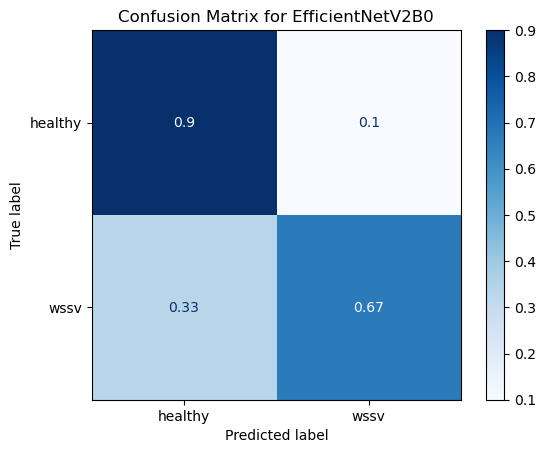

In [ ]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1).tolist()

# Get confusion matrix
cm = confusion_matrix(test_labels, predictions, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for EfficientNetV2B0")
plt.show()